In [36]:
import pandas as pd
import numpy as np
import string

In [37]:
lines= pd.read_table('./english to french/english to french.txt', names=['eng', 'fr'])

In [38]:
lines = lines[0:50000]
print(lines.head(3))
print(lines.tail(3))

    eng        fr
0   Go.      Va !
1  Run!   Cours !
2  Run!  Courez !
                            eng                              fr
49997  They go to work on foot.     Ils vont au travail à pied.
49998  They got into the train.    Ils montèrent dans le train.
49999  They got into the train.  Elles montèrent dans le train.


In [39]:
lines['eng']=lines['eng'].apply(lambda x: x.lower())
lines['fr']=lines['fr'].apply(lambda x: x.lower())

In [40]:
exclude = set(string.punctuation)
lines.eng=lines.eng.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines.fr=lines.fr.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [41]:
print(lines.head(3))
print(lines.tail(3))

   eng       fr
0   go      va 
1  run   cours 
2  run  courez 
                           eng                             fr
49997  they go to work on foot     ils vont au travail à pied
49998  they got into the train    ils montèrent dans le train
49999  they got into the train  elles montèrent dans le train


In [42]:
lines.fr = lines.fr.apply(lambda x : 'start '+ x + ' end')

In [43]:
print(lines.head(3))
print(lines.tail(3))

   eng                 fr
0   go      start va  end
1  run   start cours  end
2  run  start courez  end
                           eng                                       fr
49997  they go to work on foot     start ils vont au travail à pied end
49998  they got into the train    start ils montèrent dans le train end
49999  they got into the train  start elles montèrent dans le train end


In [44]:
lines.shape

(50000, 2)

In [45]:
# fit a tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [46]:
import json
eng_tokenizer = create_tokenizer(lines['eng'])
eng_dict=json.loads(json.dumps(eng_tokenizer.word_counts))
df =pd.DataFrame([eng_dict.keys(), eng_dict.values()]).T
df.columns = ['word','count']
print(df.head())
df = df.sort_values(by='count',ascending = False)
df['cum_count']=df['count'].cumsum()
df['cum_perc'] = df['cum_count']/df['cum_count'].max()
final_eng_words = df[df['cum_perc']<0.8]['word'].values
print(final_eng_words[:50])

   word count
0    go  1155
1   run    88
2   wow     5
3  fire    49
4  help   433
['i' 'you' 'a' 'is' 'the' 'it' 'to' 'he' 'tom' 'im' 'me' 'do' 'are' 'this'
 'that' 'dont' 'was' 'youre' 'we' 'not' 'my' 'have' 'your' 'did' 'be'
 'were' 'all' 'she' 'its' 'they' 'like' 'can' 'what' 'go' 'of' 'in' 'very'
 'want' 'no' 'how' 'here' 'him' 'on' 'cant' 'ill' 'thats' 'for' 'know'
 'get' 'up']


In [47]:
fr_tokenizer = create_tokenizer(lines['fr'])
fr_dict = json.loads(json.dumps(fr_tokenizer.word_counts))
df =pd.DataFrame([fr_dict.keys(), fr_dict.values()]).T
df.columns = ['word','count']
df = df.sort_values(by='count',ascending = False)
df['cum_count']=df['count'].cumsum()
df['cum_perc'] = df['cum_count']/df['cum_count'].max()
final_fr_words = df[df['cum_perc']<0.8]['word'].values
print(final_fr_words[:10])

['start' 'end' 'je' 'pas' 'de' 'ne' 'vous' 'il' 'le' 'est']


In [48]:
print(len(final_eng_words),len(final_fr_words))

384 357


In [49]:
def filter_eng_words(x):
  t = []
  x = x.split()
  for i in range(len(x)):
    if x[i] in final_eng_words:
      t.append(x[i])
    else:
      t.append('unk')
  x3 = ''
  for i in range(len(t)):
    x3 = x3+t[i]+' '
  return x3

In [50]:
filter_eng_words('he is extremely good')

'he is unk good '

In [51]:
def filter_fr_words(x):
  t = []
  x = x.split()
  for i in range(len(x)):
    if x[i] in final_fr_words:
      t.append(x[i])
    else:
      t.append('unk')
  x3 = ''
  for i in range(len(t)):
    x3 = x3+t[i]+' '
  return x3

In [52]:
lines['eng']=lines['eng'].apply(filter_eng_words)

In [53]:
lines['fr']=lines['fr'].apply(filter_fr_words)

In [54]:
all_eng_words=set()
for eng in lines.eng:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)
    
all_french_words=set()
for fr in lines.fr:
    for word in fr.split():
        if word not in all_french_words:
            all_french_words.add(word)

In [55]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_french_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_french_words)
# del all_eng_words, all_french_words

In [56]:
set(all_french_words) - set(final_fr_words) 

{'unk'}

In [57]:
len(all_eng_words)

385

In [58]:
len(target_words)

358

In [59]:
input_token_index = dict(
    [(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict(
    [(word, i+1) for i, word in enumerate(target_words)])

In [60]:
print(input_token_index['unk'])
print(target_token_index['start'])
print(target_token_index['end'])
print(list(input_token_index.keys())[335])
print(list(target_token_index.keys())[283])
print(list(target_token_index.keys())[88])

336
284
89
unk
start
end


In [61]:
length_list=[]
for l in lines.fr:
    length_list.append(len(l.split(' ')))
fr_max_length = np.max(length_list)

In [62]:
length_list=[]
for l in lines.eng:
    length_list.append(len(l.split(' ')))
eng_max_length = np.max(length_list)

In [63]:
print(eng_max_length)
print(fr_max_length)

8
17


In [64]:
encoder_input_data = np.zeros((len(lines['eng']), eng_max_length),dtype='float32')
decoder_input_data = np.zeros((len(lines['fr']), fr_max_length), dtype='float32')
decoder_target_data = np.zeros((len(lines['fr']), fr_max_length, num_decoder_tokens+1),dtype='float32')

In [65]:
decoder_target_data.shape

(50000, 17, 359)

In [66]:
for i, (input_text, target_text) in enumerate(zip(lines['eng'], lines['fr'])):
    for t, word in enumerate(input_text.split()):
        encoder_input_data[i, t] = input_token_index[word]
    for t, word in enumerate(target_text.split()):
        decoder_input_data[i, t] = target_token_index[word]
        if t>0:
            decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            if t== len(target_text.split())-1:
                decoder_target_data[i, t:, 89] = 1

In [67]:
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
print(encoder_input_data[49999])
print(decoder_input_data[49999])
print(decoder_target_data[49999])

[312. 124. 162. 307. 336.   0.   0.   0.]
[284.  86. 320.  63. 149. 307.  89.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [68]:
print(encoder_input_data.shape, decoder_input_data.shape, decoder_target_data.shape)

(50000, 8) (50000, 17) (50000, 17, 359)


In [69]:
print(decoder_input_data[:3])

[[284. 321.  89.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.]
 [284. 320.  89.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.]
 [284. 320.  89.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.]]


In [70]:
for i in range(decoder_input_data.shape[0]):
    for j in range(decoder_input_data.shape[1]):
        if(decoder_input_data[i][j]==0):
            decoder_input_data[i][j] = 89

print(decoder_input_data[:3])

[[284. 321.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.
   89.  89.  89.]
 [284. 320.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.
   89.  89.  89.]
 [284. 320.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.
   89.  89.  89.]]


In [38]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Bidirectional, RepeatVector, Dropout
model1 = Sequential()
model1.add(Embedding(len(input_words)+1, 128, input_shape=(eng_max_length,)))#input_words=385
model1.add(Bidirectional(LSTM(256)))
model1.add(RepeatVector(fr_max_length))
model1.add((LSTM(256, return_sequences=True)))
model1.add((Dense(len(target_token_index)+1, activation='softmax')))
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 8, 128)            49408     
_________________________________________________________________
bidirectional (Bidirectional (None, 512)               788480    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 17, 512)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 17, 256)           787456    
_________________________________________________________________
dense (Dense)                (None, 17, 359)           92263     
Total params: 1,717,607
Trainable params: 1,717,607
Non-trainable params: 0
_________________________________________________________________


In [39]:
model1.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc'])

In [40]:
history = model1.fit(encoder_input_data, decoder_target_data,
          batch_size=128, epochs=5, validation_split=0.05)

Epoch 1/5
372/372 [==============================] - 55s 135ms/step - loss: 1.5905 - acc: 0.7646 - val_loss: 1.2815 - val_acc: 0.7575
Epoch 2/5
372/372 [==============================] - 52s 141ms/step - loss: 0.9547 - acc: 0.8110 - val_loss: 1.1551 - val_acc: 0.7689
Epoch 3/5
372/372 [==============================] - 62s 167ms/step - loss: 0.8134 - acc: 0.8307 - val_loss: 1.0344 - val_acc: 0.7841
Epoch 4/5
372/372 [==============================] - 75s 201ms/step - loss: 0.7131 - acc: 0.8439 - val_loss: 0.9552 - val_acc: 0.7906
Epoch 5/5
372/372 [==============================] - 62s 167ms/step - loss: 0.6434 - acc: 0.8517 - val_loss: 0.8951 - val_acc: 0.7965


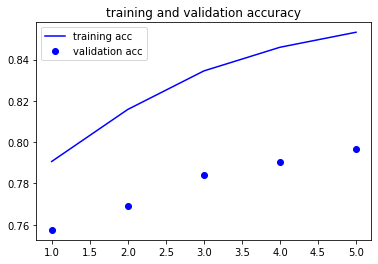

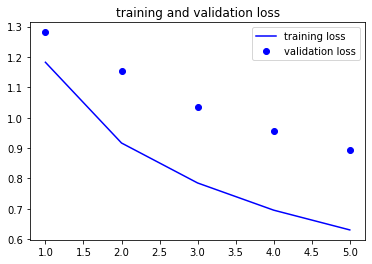

In [41]:
import matplotlib.pyplot as plt
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'b',label='training acc')
plt.plot(epochs,val_acc,'bo',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'b',label='training loss')
plt.plot(epochs,val_loss,'bo',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()


In [43]:
count = 0
correct_count = 0
pred = model1.predict(encoder_input_data[47500:])
for i in range(2500):
    t = np.argmax(pred[i], axis=-1)
    act=np.argmax(decoder_target_data[47500+i], axis=-1)
    correct_count += np.sum((act==t) & (act!=89))
    count += np.sum(act!=89)
print(correct_count, count)
print(correct_count/count)

5327 13426
0.3967674661105318


In [44]:
encoder_input_data[-2400]

array([155.,  98., 185., 336.,   0.,   0.,   0.,   0.], dtype=float32)

In [46]:
t = model1.predict(encoder_input_data[-2400].reshape(1,encoder_input_data.shape[1]))\
.reshape(decoder_input_data.shape[1], num_decoder_tokens+1)
t2 = np.argmax(t,axis=1)
for i in range(len(t2)):
  if int(t2[i])!=0:
    print(list(target_token_index.keys())[int(t2[i]-1)])
    if int(t2[i])==89:
        break


je
me
unk
unk
unk
end
